In [1]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# EXTRACTING the existing sample data

In [2]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)

"""
Parameters
"""
# We used a radius range of 0.25 to 5.0 in increments of 0.25
radius_range = np.arange(0.5,1.6,0.5)

# Step 1.1: Testing with Partial Spaces 

# 1.1 Testing our partial samples: Raw spaces

In [5]:

for radius in radius_range:
        
    t0 = time.time()
    
    with open('testing_samples/{}_partial_point_cloud.pickle'.format(radius), 'rb') as f:
        partial_point_collection = pickle.load(f)
        samples = len(partial_point_collection)
        
    partial_scores = []
    
    for obj_meta, partial_pointcloud, partial_triangles in partial_point_collection:
        
        # ROTATION
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        rotated_pointCloud = rotatePointCloud(partial_pointcloud, random_theta, random_axis)

        # TRANSLATION
        t_pointCloud = np.asarray(rotated_pointCloud)
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        t_pointCloud[:,random_tx_axis] = t_pointCloud[:,random_tx_axis] + random_translation
        t_triangles = np.asarray(partial_triangles)#-vertices_length

        t1 = time.time()

        try:
            p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                t_pointCloud,
                down_resolution = 5,
                cylindrical_quantization = [4,5]
            )
        except Exception as ex:
            print("Error getting descriptors of",obj_meta)
            print("Error Message:",ex)
            
            continue

        # Resetting the diff_Ratio matrix
        diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
        diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
        diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

        #print(diff_ratios.shape)
        local_keypoint_matches = []

        for i_r, ref_descriptor in enumerate(descriptors):

            r_descriptors = ref_descriptor[1]
            r_keypoints = ref_descriptor[2]

            matching_range = np.arange(r_descriptors.shape[1])

            try:    
                f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                diff = diff/np.amax(diff) # max-normalization of differences
                diff_ratio = diff[:,0]/diff[:,1]
                diff_ratios[:,i_r] = diff_ratio
                diff_scores[:,i_r] = diff
                diff_indexs[:,i_r] = f_nearestneighbor
                
                # Taking note of the matched keypoints
                local_keypoint_matches.append([
                    obj_meta,
                    p_keypoints,
                    r_keypoints[f_nearestneighbor[:,0]]
                ])

            except Exception as ex:
                print(rotation,"Error Matching:",ex)

        # Accumulating the diff_ratio matrix for every partial (rotated) object
        partial_scores.append([
            obj_meta,
            np.asarray(diff_ratios),
            np.asarray(diff_indexs),
            np.asarray(diff_scores),
            local_keypoint_matches
        ])

        if len(partial_scores) % 10 == (samples-1)%10:
            #print('Test')
            print(" radius = {}: Done with {} iterations. Time to match {:.3f} seconds.".format(
                radius,
                len(partial_scores),
                time.time()-t0)
                 )
            t0 = time.time()
        
            current_errors = NN_matcher(partial_scores)
            print("   Error Rate:",np.sum(current_errors[:,1]/len(partial_scores)))

    partial_errors = NN_matcher(partial_scores)
    print(radius,"Error Rate:",np.sum(partial_errors[:,1]/len(partial_scores)))
                                                                                
    with open('testing_results/partials/radius_{}_RAW_scores.pickle'.format(radius), 'wb') as f:
        pickle.dump(partial_scores,f)
                                              
    with open('testing_results/partials/radius_{}_RAW_errors.pickle'.format(radius), 'wb') as f:
        pickle.dump(partial_errors,f)


 radius = 0.5: Done with 9 iterations. Time to match 13.197 seconds.
   Error Rate: 1.0
 radius = 0.5: Done with 19 iterations. Time to match 18.614 seconds.
   Error Rate: 0.894736842105263


/srv/jaybie/spatial-privacy/nn_matchers.py:492: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


 radius = 0.5: Done with 29 iterations. Time to match 16.364 seconds.
   Error Rate: 0.8275862068965516
 radius = 0.5: Done with 39 iterations. Time to match 17.252 seconds.
   Error Rate: 0.8461538461538463
 radius = 0.5: Done with 49 iterations. Time to match 16.885 seconds.
   Error Rate: 0.8775510204081631
0.5 Error Rate: 0.8800000000000001
 radius = 1.0: Done with 9 iterations. Time to match 38.431 seconds.
   Error Rate: 0.4444444444444444
 radius = 1.0: Done with 19 iterations. Time to match 47.468 seconds.
   Error Rate: 0.42105263157894735
 radius = 1.0: Done with 29 iterations. Time to match 47.962 seconds.
   Error Rate: 0.37931034482758624
 radius = 1.0: Done with 39 iterations. Time to match 44.083 seconds.
   Error Rate: 0.35897435897435903
 radius = 1.0: Done with 49 iterations. Time to match 51.173 seconds.
   Error Rate: 0.3673469387755102
1.0 Error Rate: 0.36
 radius = 1.5: Done with 9 iterations. Time to match 46.934 seconds.
   Error Rate: 0.5555555555555556
 radius

# 1.2 Testing our partial samples: RANSAC spaces

In [6]:
for radius in radius_range:
        
    t0 = time.time()
    
    with open('testing_samples/{}_partial_point_cloud.pickle'.format(radius), 'rb') as f:
        partial_point_collection = pickle.load(f)
        samples = len(partial_point_collection)
        
    partial_scores = []
    partial_properties = []
    
    for obj_meta, partial_pointcloud, partial_triangles in partial_point_collection:
        
        # ROTATION
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        rotated_pointCloud = rotatePointCloud(partial_pointcloud, random_theta, random_axis)

        # TRANSLATION
        t_pointCloud = np.asarray(rotated_pointCloud)
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        t_pointCloud[:,random_tx_axis] = t_pointCloud[:,random_tx_axis] + random_translation
        t_triangles = np.asarray(partial_triangles)#-vertices_length

        #if object_name % 13 == 0:
        #    print('{}: Processing iteration {} of object {}.'.format(radius,iteration,object_name))

        t1 = time.time()

        # GETTING GENERALIZATION
        gen_planes = getRansacPlanes(
            t_pointCloud
        )

        p_pointcloud, p_triangles = getGeneralizedPointCloud(
            planes=gen_planes, 
        )

        try:
            p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                p_pointcloud,
                down_resolution = 5,
                cylindrical_quantization = [4,5]
            )
        except Exception as ex:
            print("Error getting descriptors of",obj_meta)
            print("Error Message:",ex)
            
            continue

        # Resetting the diff_Ratio matrix
        diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
        diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
        diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

        #print(diff_ratios.shape)
        local_keypoint_matches = []

        for i_r, ref_descriptor in enumerate(descriptors):

            #o_, r_descriptors, r_keypoints, r_d_c
            r_descriptors = ref_descriptor[1]
            r_keypoints = ref_descriptor[2]

            matching_range = np.arange(r_descriptors.shape[1])

            try:    
                f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                diff = diff/np.amax(diff) # max-normalization of differences
                diff_ratio = diff[:,0]/diff[:,1]
                diff_ratios[:,i_r] = diff_ratio
                diff_scores[:,i_r] = diff
                diff_indexs[:,i_r] = f_nearestneighbor
                
                # Taking note of the matched keypoints
                local_keypoint_matches.append([
                    obj_meta,
                    p_keypoints,
                    r_keypoints[f_nearestneighbor[:,0]]
                ])

            except Exception as ex:
                print(rotation,"Error Matching:",ex)

        # Accumulating the diff_ratio matrix for every partial (rotated) object
        partial_scores.append([
            obj_meta,
            np.asarray(diff_ratios),
            np.asarray(diff_indexs),
            np.asarray(diff_scores),
            local_keypoint_matches
        ])

        if len(partial_scores) % 10 == (samples-1)%10:
            #print('Test')
            print(" radius = {}: Done with {} iterations. Time to match {:.3f} seconds.".format(
                radius,
                len(partial_scores),
                time.time()-t0)
                 )
            t0 = time.time()
        
            current_errors = NN_matcher(partial_scores)
            print("   Error Rate:",np.sum(current_errors[:,1]/len(partial_scores)))

    partial_errors = NN_matcher(partial_scores)
    print(radius,"Error Rate:",np.sum(partial_errors[:,1]/len(partial_scores)))
                                                                                
    with open('testing_results/partials/radius_{}_RANSAC_scores.pickle'.format(radius), 'wb') as f:
        pickle.dump(partial_scores,f)
                                              
    with open('testing_results/partials/radius_{}_RANSAC_errors.pickle'.format(radius), 'wb') as f:
        pickle.dump(partial_errors,f)


/srv/jaybie/spatial-privacy/info3d.py:808: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > max(0,(1-20*threshold)):
/srv/jaybie/spatial-privacy/info3d.py:804: RuntimeWarning: invalid value encountered in double_scalars
  if abs((np.dot(testPlane[1],point[:3])+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:


 radius = 0.5: Done with 9 iterations. Time to match 31.429 seconds.
   Error Rate: 0.7777777777777777
 radius = 0.5: Done with 19 iterations. Time to match 55.529 seconds.
   Error Rate: 0.7894736842105261
 radius = 0.5: Done with 29 iterations. Time to match 42.160 seconds.
   Error Rate: 0.7586206896551723
 radius = 0.5: Done with 39 iterations. Time to match 40.566 seconds.
   Error Rate: 0.7179487179487181
 radius = 0.5: Done with 49 iterations. Time to match 49.864 seconds.
   Error Rate: 0.7346938775510203
0.5 Error Rate: 0.74
 radius = 1.0: Done with 9 iterations. Time to match 94.560 seconds.
   Error Rate: 0.5555555555555556
 radius = 1.0: Done with 19 iterations. Time to match 116.093 seconds.
   Error Rate: 0.631578947368421
 radius = 1.0: Done with 29 iterations. Time to match 123.649 seconds.
   Error Rate: 0.5517241379310344
 radius = 1.0: Done with 39 iterations. Time to match 93.627 seconds.
   Error Rate: 0.5897435897435898
 radius = 1.0: Done with 49 iterations. Time

# 1.1.3 Results of partial spaces

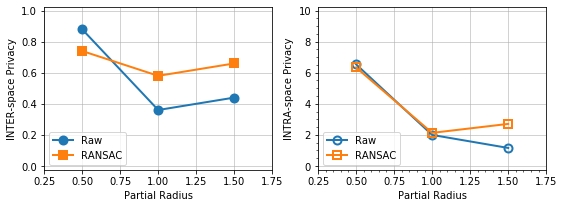

In [9]:
fig=plt.figure(figsize=(9, 3))

RawNN = []
RansacGeneralizedNN = []

RawNN_intra_errors = []
RansacGeneralizedNN_intra_errors = []

for radius in radius_range:
    
    try:
        with open('testing_results/partials/radius_{}_RAW_errors.pickle'.format(radius), 'rb') as f:
            partial_errors = pickle.load(f)

        RawNN.append([
            radius,
            np.mean(partial_errors[:,1]),
            np.std(partial_errors[:,1]),
        ])
        
        correct_interspace_labels_idxs = np.where(partial_errors[:,1]==0)[0]

        intraspace_errors  = partial_errors[correct_interspace_labels_idxs,2]

        RawNN_intra_errors.append([
            radius,
            np.nanmean(intraspace_errors),
            np.nanstd(intraspace_errors)
        ])
        
    except:
        pass
    
    try:
        with open('testing_results/partials/radius_{}_RANSAC_errors.pickle'.format(radius), 'rb') as f:
            partial_errors = pickle.load(f)

        RansacGeneralizedNN.append([
            radius,
            np.nanmean(partial_errors[:,1]),
            np.nanstd(partial_errors[:,1]),
        ])

        correct_interspace_labels_idxs = np.where(partial_errors[:,1]==0)[0]

        intraspace_errors  = partial_errors[correct_interspace_labels_idxs,2]

        RansacGeneralizedNN_intra_errors.append([
            radius,
            np.nanmean(intraspace_errors),
            np.nanstd(intraspace_errors)
        ])
        
    except:
        pass
    
RansacGeneralizedNN = np.asarray(RansacGeneralizedNN)
RawNN = np.asarray(RawNN)

RawNN_intra_errors = np.asarray(RawNN_intra_errors)
RansacGeneralizedNN_intra_errors = np.asarray(RansacGeneralizedNN_intra_errors)

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(radius_range[0]-0.25,radius_range[-1]+0.25)
markersize = 8

ax1.set_ylabel("INTER-space Privacy")
ax1.set_xlabel("Partial Radius")
#ax1.set_yticklabels(fontsize = 16)
#ax1.set_xticklabels(fontsize = 16)

ax1.plot(
    RawNN[:,0],RawNN[:,1],
    "-o",
    linewidth = 2,
    mew = 2,markersize = markersize,
    label = "Raw"
)
ax1.plot(
    RansacGeneralizedNN[:,0],RansacGeneralizedNN[:,1],
    "-s",
    linewidth = 2,
    mew = 2,markersize = markersize,
    label = "RANSAC"
)

ax1.legend(loc = "lower left")

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(radius_range[0]-0.25,radius_range[-1]+0.25)

ax2.set_ylabel("INTRA-space Privacy")
ax2.set_xlabel("Partial Radius")
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

plt.minorticks_on()

ax2.plot(
    RawNN_intra_errors[:,0],
    RawNN_intra_errors[:,1], 
    linewidth = 2,
    marker = 'o',fillstyle = 'none',
    mew = 2,markersize = markersize,
    label = "Raw"
)

ax2.plot(
    RansacGeneralizedNN_intra_errors[:,0],
    RansacGeneralizedNN_intra_errors[:,1], 
    linewidth = 2, 
    marker = 's',fillstyle = 'none',
    mew = 2,markersize = markersize,
    label = "RANSAC"
)

ax2.legend(loc = "lower left")

# Step 2 Testing with successively released partial spaces

In [8]:
"""
Parameters
"""
# We used a radius range of 0.25 to 5.0 in increments of 0.25.
radius_range = radius_range

# For our work, we orignally used 50 samples with further 100 successive releases for our investigation.
# Below are lower parameters, change as desired.
samples = 50
releases = 50

# For demonstration purposes, we skip testing some successive samples but we still accumulate them.
skip = 3

# 2.1 Testing the successive case: RAW and RANSAC

In [5]:
for radius in radius_range:
        
    t0 = time.time()
    
    try:
        with open('testing_samples/{}_successive_point_cloud.pickle'.format(radius), 'rb') as f:
            successive_point_collection = pickle.load(f)
            samples = len(successive_point_collection)

    except:
        pass
    
    successive_scores = []
    successive_errors = []
    
    g_successive_scores = []
    g_successive_errors = []

    for obj_, growing_point_collection in successive_point_collection:
        
        iteration_scores = []
        
        g_iteration_scores = []
        
        # ROTATION param
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        
        # TRANSLATION param
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        
        growing_point_cloud = []
        growing_p_point_cloud = []
        growing_p_triangles = []
        
        releases = len(growing_point_collection)
        release_count = 0
    
        for obj_meta, partial_pointcloud, partial_triangles in growing_point_collection:
            #i_obj, released_growing_point_collection in enumerate(growing_point_collection):

            rotated_pointCloud = rotatePointCloud(partial_pointcloud, random_theta, random_axis)

            # TRANSLATION
            t_pointCloud = np.asarray(rotated_pointCloud)
            t_pointCloud[:,random_tx_axis] = t_pointCloud[:,random_tx_axis] + random_translation
            t_triangles = np.asarray(partial_triangles)#-vertices_length
            
            #Regular Accumulation
            if len(growing_point_cloud) == 0:
                growing_point_cloud = t_pointCloud

            else:
                growing_point_cloud = np.concatenate(
                    (growing_point_cloud,t_pointCloud),
                    axis=0
                )
                
            #RANSAC generalizations
            if len(growing_p_point_cloud) == 0:
                gen_planes = getLOCALIZEDRansacPlanes(
                    pointCloud = t_pointCloud,
                    original_vertex = obj_meta[-1]
                )
            else:
                gen_planes = updatePlanesWithSubsumption(
                    new_pointCloud=t_pointCloud,
                    existing_pointCloud=growing_p_point_cloud,
                    planes_to_find = max(min(release_count,50),30),
                    #verbose=True
                )
            
            if len(gen_planes) == 0:
                print("No gen planes after release",release_count,growing_point_cloud.shape)
                continue

            try:
                updated_point_cloud, updated_triangles = getGeneralizedPointCloud(
                    planes = gen_planes,
                    triangle_area_threshold = 0.2,#2.0*np.amax(getTriangleAreas(partial_pointCloud, partial_triangles))
                    #verbose = True
                )
                growing_p_point_cloud = updated_point_cloud
                growing_p_triangles = updated_triangles
                
                #print(" Successful:",release_count,len(growing_p_point_cloud), len(growing_p_triangles),partial_pointCloud.shape)
            except Exception as ex:
                print("Error getting updated point cloud in release",release_count+1)
                print(" ",growing_p_point_cloud.shape, growing_p_triangles.shape,partial_pointCloud.shape)
                #print(ex)
                continue
                
            if len(growing_p_point_cloud) == 0:
                continue
                
            release_count += 1
            
            if release_count % skip != 1: # skip 
                continue
                
            #Regular Processing
            growing_point_cloud = np.unique(growing_point_cloud,axis=0)
            
            try:
                p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                    growing_point_cloud,
                    down_resolution = 5,
                    cylindrical_quantization = [4,5]
                )
            except:
                p_descriptors = []
                p_keypoints = []

            # Resetting the diff_Ratio matrix
            diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
            diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
            diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

            local_keypoint_matches = []

            for i_r, ref_descriptor in enumerate(descriptors):

                r_descriptors = ref_descriptor[1]
                r_keypoints = ref_descriptor[2]

                matching_range = np.arange(r_descriptors.shape[1])

                try:    
                    f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                    diff = diff/np.amax(diff) # max-normalization of differences
                    diff_ratio = diff[:,0]/diff[:,1]
                    diff_ratios[:,i_r] = diff_ratio
                    diff_scores[:,i_r] = diff
                    diff_indexs[:,i_r] = f_nearestneighbor

                    # Taking note of the matched keypoints
                    local_keypoint_matches.append([
                        obj_meta,
                        p_keypoints,
                        r_keypoints[f_nearestneighbor[:,0]]
                    ])

                except Exception as ex:
                    print(rotation,"Error Matching:",ex)

            # Accumulating the diff_ratio matrix for every partial (rotated) object
            iteration_scores.append([
                obj_meta,
                diff_ratios,
                diff_indexs,
                diff_scores,
                local_keypoint_matches
            ])

            if release_count % 2 == 0:
                #print('Test')
                print("  radius = {}: Done with {} releases ({}) ({} samples). Time to match {:.3f} seconds. ({})".format(
                    radius,
                    len(iteration_scores),
                    release_count,
                    len(successive_scores),
                    time.time()-t0,
                    growing_point_cloud.shape
                )
                     )
                t0 = time.time()

                current_errors = NN_matcher(iteration_scores)
                print("   Error Rate:",np.sum(current_errors[:,1]/len(iteration_scores)))
            
            #RANSAC Processing         
            try:
                p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                    growing_p_point_cloud,
                    down_resolution = 5,
                    cylindrical_quantization = [4,5]
                )
            except:
                p_descriptors = []
                p_keypoints = []
                
                print("Error getting descriptors at release",release_count,"; using next release as this release.")
                
                #release_count -= 1

                continue

            # Resetting the diff_Ratio matrix
            diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
            diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
            diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

            local_keypoint_matches = []

            for i_r, ref_descriptor in enumerate(descriptors):

                #o_, r_descriptors, r_keypoints, r_d_c
                r_descriptors = ref_descriptor[1]
                r_keypoints = ref_descriptor[2]

                matching_range = np.arange(r_descriptors.shape[1])

                try:    
                    f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                    diff = diff/np.amax(diff) # max-normalization of differences
                    diff_ratio = diff[:,0]/diff[:,1]
                    diff_ratios[:,i_r] = diff_ratio
                    diff_scores[:,i_r] = diff
                    diff_indexs[:,i_r] = f_nearestneighbor

                    # Taking note of the matched keypoints
                    local_keypoint_matches.append([
                        obj_meta,
                        p_keypoints,
                        r_keypoints[f_nearestneighbor[:,0]]
                    ])

                except Exception as ex:
                    print(rotation,"Error Matching:",ex)

            # Accumulating the diff_ratio matrix for every partial (rotated) object
            g_iteration_scores.append([
                obj_meta,
                diff_ratios,
                diff_indexs,
                diff_scores,
                local_keypoint_matches
            ])

            if release_count % 2 == 0:
                #print('Test')
                print("  radius = {} [G]: Done with {} releases ({}) ({} samples). Time to match {:.3f} seconds. ({})".format(
                    radius,
                    len(g_iteration_scores),
                    release_count,
                    len(g_successive_scores),
                    time.time()-t0,
                    growing_p_point_cloud.shape
                )
                     )
                t0 = time.time()

                current_errors = NN_matcher(g_iteration_scores)
                print("   G_Error Rate:",np.sum(current_errors[:,1]/len(g_iteration_scores)))

        iteration_errors = NN_matcher(iteration_scores)

        g_iteration_errors = NN_matcher(g_iteration_scores)

        if len(successive_scores) % 5 == (samples-1)%5 :
            try:
                print(radius,len(successive_scores),"Error Rate:",np.sum(iteration_errors[:,1]/len(iteration_scores)))
                print(radius,len(g_successive_scores),"G_Error Rate:",np.sum(g_iteration_errors[:,1]/len(g_iteration_scores)))
            except:
                pass
            
        successive_scores.append([
            obj_,
            iteration_scores
        ])
        
        successive_errors.append([
            obj_,
            iteration_errors
        ])
        
        g_successive_scores.append([
            obj_,
            g_iteration_scores
        ])
        
        g_successive_errors.append([
            obj_,
            g_iteration_errors
        ])
    
        with open('testing_results/successive/radius_{}_RAW_successive_scores.pickle'.format(radius), 'wb') as f:
            pickle.dump(successive_scores,f)

        with open('testing_results/successive/radius_{}_RAW_successive_errors.pickle'.format(radius), 'wb') as f:
            pickle.dump(successive_errors,f)

        with open('testing_results/successive/radius_{}_RANSAC_successive_scores.pickle'.format(radius), 'wb') as f:
            pickle.dump(g_successive_scores,f)

        with open('testing_results/successive/radius_{}_RANSAC_successive_errors.pickle'.format(radius), 'wb') as f:
            pickle.dump(g_successive_errors,f)

/srv/jaybie/spatial-privacy/info3d.py:889: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(firstPlane[1],point[3:])/(LA.norm(firstPlane[1])*LA.norm(point[3:]))) > (1-20*threshold):


  radius = 0.5: Done with 2 releases (4) (0 samples). Time to match 11.266 seconds. ((1245, 6))
   Error Rate: 1.0
  radius = 0.5 [G]: Done with 2 releases (4) (0 samples). Time to match 3.400 seconds. ((955, 6))
   G_Error Rate: 0.5


/srv/jaybie/spatial-privacy/nn_matchers.py:492: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


  radius = 0.5: Done with 4 releases (10) (0 samples). Time to match 24.168 seconds. ((1894, 6))
   Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (0 samples). Time to match 6.499 seconds. ((1927, 6))
   G_Error Rate: 0.75


/srv/jaybie/spatial-privacy/info3d.py:1011: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > max(0,(1-20*threshold)):


  radius = 0.5: Done with 6 releases (16) (0 samples). Time to match 28.166 seconds. ((2749, 6))
   Error Rate: 0.8333333333333333
  radius = 0.5 [G]: Done with 6 releases (16) (0 samples). Time to match 11.476 seconds. ((4711, 6))
   G_Error Rate: 0.8333333333333333
  radius = 0.5: Done with 8 releases (22) (0 samples). Time to match 48.772 seconds. ((3614, 6))
   Error Rate: 0.75
  radius = 0.5 [G]: Done with 8 releases (22) (0 samples). Time to match 19.033 seconds. ((7874, 6))
   G_Error Rate: 0.625
  radius = 0.5: Done with 10 releases (28) (0 samples). Time to match 69.814 seconds. ((4660, 6))
   Error Rate: 0.6000000000000001
  radius = 0.5 [G]: Done with 10 releases (28) (0 samples). Time to match 28.025 seconds. ((10015, 6))
   G_Error Rate: 0.6
  radius = 0.5: Done with 12 releases (34) (0 samples). Time to match 84.069 seconds. ((5348, 6))
   Error Rate: 0.5
  radius = 0.5 [G]: Done with 12 releases (34) (0 samples). Time to match 29.866 seconds. ((9588, 6))
   G_Error Rate:

/srv/jaybie/spatial-privacy/info3d.py:808: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > max(0,(1-20*threshold)):


  radius = 0.5: Done with 2 releases (4) (1 samples). Time to match 18.121 seconds. ((972, 6))
   Error Rate: 1.0
  radius = 0.5 [G]: Done with 2 releases (4) (1 samples). Time to match 5.840 seconds. ((1212, 6))
   G_Error Rate: 1.0
  radius = 0.5: Done with 4 releases (10) (1 samples). Time to match 35.498 seconds. ((1523, 6))
   Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (1 samples). Time to match 12.419 seconds. ((2603, 6))
   G_Error Rate: 0.75
  radius = 0.5: Done with 6 releases (16) (1 samples). Time to match 40.062 seconds. ((1717, 6))
   Error Rate: 0.9999999999999999
  radius = 0.5 [G]: Done with 6 releases (16) (1 samples). Time to match 15.070 seconds. ((3231, 6))
   G_Error Rate: 0.6666666666666666
  radius = 0.5: Done with 8 releases (22) (1 samples). Time to match 50.605 seconds. ((2358, 6))
   Error Rate: 0.875
  radius = 0.5 [G]: Done with 8 releases (22) (1 samples). Time to match 21.202 seconds. ((4625, 6))
   G_Error Rate: 0.75


/srv/jaybie/spatial-privacy/info3d.py:804: RuntimeWarning: invalid value encountered in double_scalars
  if abs((np.dot(testPlane[1],point[:3])+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:


  radius = 0.5: Done with 10 releases (28) (1 samples). Time to match 74.662 seconds. ((3100, 6))
   Error Rate: 0.7000000000000001
  radius = 0.5 [G]: Done with 10 releases (28) (1 samples). Time to match 31.292 seconds. ((7463, 6))
   G_Error Rate: 0.7000000000000001
  radius = 0.5: Done with 12 releases (34) (1 samples). Time to match 85.876 seconds. ((3348, 6))
   Error Rate: 0.5833333333333333
  radius = 0.5 [G]: Done with 12 releases (34) (1 samples). Time to match 37.187 seconds. ((8608, 6))
   G_Error Rate: 0.6666666666666667
  radius = 0.5: Done with 14 releases (40) (1 samples). Time to match 87.188 seconds. ((3692, 6))
   Error Rate: 0.5
  radius = 0.5 [G]: Done with 14 releases (40) (1 samples). Time to match 38.674 seconds. ((8474, 6))
   G_Error Rate: 0.6428571428571428
  radius = 0.5: Done with 16 releases (46) (1 samples). Time to match 99.265 seconds. ((3838, 6))
   Error Rate: 0.4375
  radius = 0.5 [G]: Done with 16 releases (46) (1 samples). Time to match 40.396 seco

  radius = 0.5: Done with 16 releases (46) (5 samples). Time to match 49.808 seconds. ((2392, 6))
   Error Rate: 0.125
  radius = 0.5 [G]: Done with 16 releases (46) (5 samples). Time to match 14.443 seconds. ((2882, 6))
   G_Error Rate: 0.3125
  radius = 0.5: Done with 2 releases (4) (6 samples). Time to match 71.266 seconds. ((2038, 6))
   Error Rate: 0.5
  radius = 0.5 [G]: Done with 2 releases (4) (6 samples). Time to match 6.623 seconds. ((1547, 6))
   G_Error Rate: 1.0
  radius = 0.5: Done with 4 releases (10) (6 samples). Time to match 46.089 seconds. ((2280, 6))
   Error Rate: 0.25
  radius = 0.5 [G]: Done with 4 releases (10) (6 samples). Time to match 11.285 seconds. ((2456, 6))
   G_Error Rate: 1.0
  radius = 0.5: Done with 6 releases (16) (6 samples). Time to match 53.038 seconds. ((2360, 6))
   Error Rate: 0.16666666666666666
  radius = 0.5 [G]: Done with 6 releases (16) (6 samples). Time to match 15.044 seconds. ((3137, 6))
   G_Error Rate: 0.6666666666666666
  radius = 0

  radius = 0.5: Done with 8 releases (22) (10 samples). Time to match 46.193 seconds. ((1905, 6))
   Error Rate: 0.375
  radius = 0.5 [G]: Done with 8 releases (22) (10 samples). Time to match 14.653 seconds. ((3037, 6))
   G_Error Rate: 0.625
  radius = 0.5: Done with 10 releases (28) (10 samples). Time to match 41.914 seconds. ((1994, 6))
   Error Rate: 0.30000000000000004
  radius = 0.5 [G]: Done with 10 releases (28) (10 samples). Time to match 18.385 seconds. ((4510, 6))
   G_Error Rate: 0.5
  radius = 0.5: Done with 12 releases (34) (10 samples). Time to match 62.597 seconds. ((2980, 6))
   Error Rate: 0.25
  radius = 0.5 [G]: Done with 12 releases (34) (10 samples). Time to match 22.621 seconds. ((5283, 6))
   G_Error Rate: 0.49999999999999994
  radius = 0.5: Done with 14 releases (40) (10 samples). Time to match 67.886 seconds. ((3315, 6))
   Error Rate: 0.21428571428571427
  radius = 0.5 [G]: Done with 14 releases (40) (10 samples). Time to match 25.969 seconds. ((6921, 6))
  

  radius = 0.5: Done with 14 releases (40) (17 samples). Time to match 101.190 seconds. ((5069, 6))
   Error Rate: 0.14285714285714285
  radius = 0.5 [G]: Done with 14 releases (40) (17 samples). Time to match 40.800 seconds. ((11311, 6))
   G_Error Rate: 0.7142857142857142
  radius = 0.5: Done with 2 releases (4) (18 samples). Time to match 131.046 seconds. ((3128, 6))
   Error Rate: 0.5
  radius = 0.5 [G]: Done with 2 releases (4) (18 samples). Time to match 6.092 seconds. ((1371, 6))
   G_Error Rate: 1.0
  radius = 0.5: Done with 4 releases (10) (18 samples). Time to match 76.707 seconds. ((3877, 6))
   Error Rate: 0.25
  radius = 0.5 [G]: Done with 4 releases (10) (18 samples). Time to match 11.711 seconds. ((2266, 6))
   G_Error Rate: 0.75
  radius = 0.5: Done with 6 releases (16) (18 samples). Time to match 75.921 seconds. ((3982, 6))
   Error Rate: 0.16666666666666666
  radius = 0.5 [G]: Done with 6 releases (16) (18 samples). Time to match 13.743 seconds. ((2555, 6))
   G_Error

0.5 24 Error Rate: 0.125
0.5 24 G_Error Rate: 0.3125
  radius = 0.5: Done with 2 releases (4) (25 samples). Time to match 15.896 seconds. ((902, 6))
   Error Rate: 0.0
  radius = 0.5 [G]: Done with 2 releases (4) (25 samples). Time to match 3.292 seconds. ((508, 6))
   G_Error Rate: 0.5
  radius = 0.5: Done with 4 releases (10) (25 samples). Time to match 44.733 seconds. ((2317, 6))
   Error Rate: 0.0
  radius = 0.5 [G]: Done with 4 releases (10) (25 samples). Time to match 12.834 seconds. ((2925, 6))
   G_Error Rate: 0.75
  radius = 0.5: Done with 6 releases (16) (25 samples). Time to match 64.092 seconds. ((2756, 6))
   Error Rate: 0.0
  radius = 0.5 [G]: Done with 6 releases (16) (25 samples). Time to match 16.340 seconds. ((3539, 6))
   G_Error Rate: 0.8333333333333333
  radius = 0.5: Done with 8 releases (22) (25 samples). Time to match 67.505 seconds. ((3128, 6))
   Error Rate: 0.0
  radius = 0.5 [G]: Done with 8 releases (22) (25 samples). Time to match 21.033 seconds. ((5076, 6

  radius = 0.5 [G]: Done with 2 releases (4) (29 samples). Time to match 5.942 seconds. ((1238, 6))
   G_Error Rate: 1.0
  radius = 0.5: Done with 4 releases (10) (29 samples). Time to match 56.775 seconds. ((2659, 6))
   Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (29 samples). Time to match 13.997 seconds. ((3010, 6))
   G_Error Rate: 1.0
  radius = 0.5: Done with 6 releases (16) (29 samples). Time to match 68.055 seconds. ((3609, 6))
   Error Rate: 0.9999999999999999
  radius = 0.5 [G]: Done with 6 releases (16) (29 samples). Time to match 28.778 seconds. ((6800, 6))
   G_Error Rate: 0.9999999999999999
  radius = 0.5: Done with 8 releases (22) (29 samples). Time to match 104.966 seconds. ((4326, 6))
   Error Rate: 0.875
  radius = 0.5 [G]: Done with 8 releases (22) (29 samples). Time to match 37.873 seconds. ((8116, 6))
   G_Error Rate: 1.0
  radius = 0.5: Done with 10 releases (28) (29 samples). Time to match 107.651 seconds. ((4627, 6))
   Error Rate: 0.700000000

  radius = 0.5 [G]: Done with 12 releases (34) (33 samples). Time to match 36.758 seconds. ((7255, 6))
   G_Error Rate: 0.9166666666666667
  radius = 0.5: Done with 14 releases (40) (33 samples). Time to match 93.209 seconds. ((3427, 6))
   Error Rate: 0.5714285714285714
  radius = 0.5 [G]: Done with 14 releases (40) (33 samples). Time to match 38.638 seconds. ((7701, 6))
   G_Error Rate: 0.9285714285714284
  radius = 0.5: Done with 16 releases (46) (33 samples). Time to match 102.229 seconds. ((4213, 6))
   Error Rate: 0.5
  radius = 0.5 [G]: Done with 16 releases (46) (33 samples). Time to match 43.232 seconds. ((7715, 6))
   G_Error Rate: 0.875
  radius = 0.5: Done with 2 releases (4) (35 samples). Time to match 25.342 seconds. ((1271, 6))
   Error Rate: 1.0
  radius = 0.5 [G]: Done with 2 releases (4) (35 samples). Time to match 6.976 seconds. ((1213, 6))
   G_Error Rate: 1.0
  radius = 0.5: Done with 4 releases (10) (35 samples). Time to match 43.666 seconds. ((2031, 6))
   Error 

  radius = 0.5: Done with 8 releases (22) (39 samples). Time to match 33.590 seconds. ((1917, 6))
   Error Rate: 0.125
  radius = 0.5 [G]: Done with 8 releases (22) (39 samples). Time to match 14.707 seconds. ((4419, 6))
   G_Error Rate: 0.375
  radius = 0.5: Done with 10 releases (28) (39 samples). Time to match 54.797 seconds. ((2705, 6))
   Error Rate: 0.1
  radius = 0.5 [G]: Done with 10 releases (28) (39 samples). Time to match 21.987 seconds. ((7116, 6))
   G_Error Rate: 0.5
  radius = 0.5: Done with 12 releases (34) (39 samples). Time to match 65.926 seconds. ((3254, 6))
   Error Rate: 0.08333333333333333
  radius = 0.5 [G]: Done with 12 releases (34) (39 samples). Time to match 28.181 seconds. ((8647, 6))
   G_Error Rate: 0.49999999999999994
  radius = 0.5: Done with 14 releases (40) (39 samples). Time to match 80.158 seconds. ((3623, 6))
   Error Rate: 0.07142857142857142
  radius = 0.5 [G]: Done with 14 releases (40) (39 samples). Time to match 28.322 seconds. ((7339, 6))
   

  radius = 0.5: Done with 6 releases (16) (44 samples). Time to match 38.727 seconds. ((2268, 6))
   Error Rate: 0.0
  radius = 0.5 [G]: Done with 6 releases (16) (44 samples). Time to match 13.980 seconds. ((2572, 6))
   G_Error Rate: 0.8333333333333333
  radius = 0.5: Done with 8 releases (22) (44 samples). Time to match 47.564 seconds. ((2425, 6))
   Error Rate: 0.0
  radius = 0.5 [G]: Done with 8 releases (22) (44 samples). Time to match 15.788 seconds. ((3101, 6))
   G_Error Rate: 0.875
  radius = 0.5: Done with 10 releases (28) (44 samples). Time to match 52.588 seconds. ((2628, 6))
   Error Rate: 0.0
  radius = 0.5 [G]: Done with 10 releases (28) (44 samples). Time to match 24.510 seconds. ((7056, 6))
   G_Error Rate: 0.8
  radius = 0.5: Done with 12 releases (34) (44 samples). Time to match 59.146 seconds. ((2639, 6))
   Error Rate: 0.0
  radius = 0.5 [G]: Done with 12 releases (34) (44 samples). Time to match 20.956 seconds. ((4182, 6))
   G_Error Rate: 0.6666666666666666
  ra

  radius = 0.5: Done with 12 releases (34) (48 samples). Time to match 37.666 seconds. ((1808, 6))
   Error Rate: 0.08333333333333333
  radius = 0.5 [G]: Done with 12 releases (34) (48 samples). Time to match 13.784 seconds. ((2985, 6))
   G_Error Rate: 0.7500000000000001
  radius = 0.5: Done with 14 releases (40) (48 samples). Time to match 48.426 seconds. ((1872, 6))
   Error Rate: 0.07142857142857142
  radius = 0.5 [G]: Done with 14 releases (40) (48 samples). Time to match 16.254 seconds. ((3247, 6))
   G_Error Rate: 0.7857142857142856
  radius = 0.5: Done with 16 releases (46) (48 samples). Time to match 55.616 seconds. ((1955, 6))
   Error Rate: 0.0625
  radius = 0.5 [G]: Done with 16 releases (46) (48 samples). Time to match 17.708 seconds. ((3469, 6))
   G_Error Rate: 0.75
  radius = 0.5: Done with 2 releases (4) (49 samples). Time to match 52.270 seconds. ((900, 6))
   Error Rate: 1.0
  radius = 0.5 [G]: Done with 2 releases (4) (49 samples). Time to match 3.011 seconds. ((767

  radius = 1.0 [G]: Done with 14 releases (40) (2 samples). Time to match 40.160 seconds. ((8944, 6))
   G_Error Rate: 0.5
  radius = 1.0: Done with 16 releases (46) (2 samples). Time to match 114.850 seconds. ((4517, 6))
   Error Rate: 0.0625
  radius = 1.0 [G]: Done with 16 releases (46) (2 samples). Time to match 37.326 seconds. ((8351, 6))
   G_Error Rate: 0.4375
  radius = 1.0: Done with 2 releases (4) (3 samples). Time to match 116.416 seconds. ((2178, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 2 releases (4) (3 samples). Time to match 6.073 seconds. ((1371, 6))
   G_Error Rate: 1.0
  radius = 1.0: Done with 4 releases (10) (3 samples). Time to match 52.866 seconds. ((2896, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 4 releases (10) (3 samples). Time to match 15.731 seconds. ((3857, 6))
   G_Error Rate: 0.75
  radius = 1.0: Done with 6 releases (16) (3 samples). Time to match 90.203 seconds. ((3862, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 6 release

  radius = 1.0 [G]: Done with 2 releases (4) (8 samples). Time to match 8.194 seconds. ((1335, 6))
   G_Error Rate: 0.0
  radius = 1.0: Done with 4 releases (10) (8 samples). Time to match 46.169 seconds. ((1739, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 4 releases (10) (8 samples). Time to match 11.924 seconds. ((1788, 6))
   G_Error Rate: 0.0
  radius = 1.0: Done with 6 releases (16) (8 samples). Time to match 46.776 seconds. ((1763, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 6 releases (16) (8 samples). Time to match 12.568 seconds. ((1880, 6))
   G_Error Rate: 0.16666666666666666
  radius = 1.0: Done with 8 releases (22) (8 samples). Time to match 44.969 seconds. ((1768, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 8 releases (22) (8 samples). Time to match 13.190 seconds. ((2295, 6))
   G_Error Rate: 0.25
  radius = 1.0: Done with 10 releases (28) (8 samples). Time to match 51.478 seconds. ((1999, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 10

/srv/jaybie/spatial-privacy/info3d.py:885: RuntimeWarning: invalid value encountered in double_scalars
  if abs((np.dot(firstPlane[1],point[:3])+d)*1.0/LA.norm(firstPlane[1],ord = 2)) < threshold:
/srv/jaybie/spatial-privacy/info3d.py:591: RuntimeWarning: invalid value encountered in double_scalars
  phi = math.fabs(plane_params[1][1]* 1./LA.norm(plane_params[1])) # y/r


  radius = 1.0: Done with 2 releases (4) (9 samples). Time to match 137.988 seconds. ((3188, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 2 releases (4) (9 samples). Time to match 7.257 seconds. ((1849, 6))
   G_Error Rate: 0.0
  radius = 1.0: Done with 4 releases (10) (9 samples). Time to match 64.875 seconds. ((3200, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 4 releases (10) (9 samples). Time to match 10.120 seconds. ((2479, 6))
   G_Error Rate: 0.5
  radius = 1.0: Done with 6 releases (16) (9 samples). Time to match 77.580 seconds. ((4490, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 6 releases (16) (9 samples). Time to match 23.406 seconds. ((6636, 6))
   G_Error Rate: 0.5
  radius = 1.0: Done with 8 releases (22) (9 samples). Time to match 84.444 seconds. ((4821, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 8 releases (22) (9 samples). Time to match 21.844 seconds. ((5841, 6))
   G_Error Rate: 0.5
  radius = 1.0: Done with 10 releases (28) (9 samp

  radius = 1.0: Done with 10 releases (28) (13 samples). Time to match 89.179 seconds. ((3398, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 10 releases (28) (13 samples). Time to match 28.717 seconds. ((6158, 6))
   G_Error Rate: 0.30000000000000004
  radius = 1.0: Done with 12 releases (34) (13 samples). Time to match 95.450 seconds. ((4171, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 12 releases (34) (13 samples). Time to match 34.634 seconds. ((7087, 6))
   G_Error Rate: 0.41666666666666663
  radius = 1.0: Done with 14 releases (40) (13 samples). Time to match 108.594 seconds. ((4204, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 14 releases (40) (13 samples). Time to match 35.104 seconds. ((7167, 6))
   G_Error Rate: 0.3571428571428571
  radius = 1.0: Done with 2 releases (4) (14 samples). Time to match 123.961 seconds. ((2640, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 2 releases (4) (14 samples). Time to match 13.950 seconds. ((2522, 6))
   G_Err

  radius = 1.0: Done with 14 releases (40) (17 samples). Time to match 102.995 seconds. ((5552, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 14 releases (40) (17 samples). Time to match 28.761 seconds. ((6325, 6))
   G_Error Rate: 0.4285714285714285
  radius = 1.0: Done with 2 releases (4) (18 samples). Time to match 151.468 seconds. ((5119, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 2 releases (4) (18 samples). Time to match 13.211 seconds. ((2427, 6))
   G_Error Rate: 0.5
  radius = 1.0: Done with 4 releases (10) (18 samples). Time to match 134.676 seconds. ((6351, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 4 releases (10) (18 samples). Time to match 25.654 seconds. ((4576, 6))
   G_Error Rate: 0.25
  radius = 1.0: Done with 6 releases (16) (18 samples). Time to match 139.176 seconds. ((7162, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 6 releases (16) (18 samples). Time to match 40.326 seconds. ((7772, 6))
   G_Error Rate: 0.3333333333333333
  rad

  radius = 1.0: Done with 10 releases (28) (22 samples). Time to match 97.675 seconds. ((5081, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 10 releases (28) (22 samples). Time to match 31.903 seconds. ((6905, 6))
   G_Error Rate: 0.30000000000000004
  radius = 1.0: Done with 12 releases (34) (22 samples). Time to match 104.525 seconds. ((5224, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 12 releases (34) (22 samples). Time to match 36.501 seconds. ((8360, 6))
   G_Error Rate: 0.3333333333333333
  radius = 1.0: Done with 14 releases (40) (22 samples). Time to match 121.436 seconds. ((5439, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 14 releases (40) (22 samples). Time to match 41.567 seconds. ((9114, 6))
   G_Error Rate: 0.2857142857142857
  radius = 1.0: Done with 2 releases (4) (23 samples). Time to match 130.779 seconds. ((2343, 6))
   Error Rate: 0.5
  radius = 1.0 [G]: Done with 2 releases (4) (23 samples). Time to match 11.561 seconds. ((2597, 6))
   G_Err

  radius = 1.0 [G]: Done with 12 releases (34) (26 samples). Time to match 38.290 seconds. ((10322, 6))
   G_Error Rate: 0.49999999999999994
  radius = 1.0: Done with 14 releases (40) (26 samples). Time to match 100.304 seconds. ((4752, 6))
   Error Rate: 0.07142857142857142
  radius = 1.0 [G]: Done with 14 releases (40) (26 samples). Time to match 35.944 seconds. ((8463, 6))
   G_Error Rate: 0.4999999999999999
  radius = 1.0: Done with 16 releases (46) (26 samples). Time to match 106.110 seconds. ((4754, 6))
   Error Rate: 0.0625
  radius = 1.0 [G]: Done with 16 releases (46) (26 samples). Time to match 29.657 seconds. ((6106, 6))
   G_Error Rate: 0.4375
  radius = 1.0: Done with 2 releases (4) (27 samples). Time to match 55.185 seconds. ((2467, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 2 releases (4) (27 samples). Time to match 13.598 seconds. ((2041, 6))
   G_Error Rate: 0.5
  radius = 1.0: Done with 4 releases (10) (27 samples). Time to match 77.984 seconds. ((3801, 6))


  radius = 1.0 [G]: Done with 16 releases (46) (30 samples). Time to match 52.565 seconds. ((10973, 6))
   G_Error Rate: 0.6875
  radius = 1.0: Done with 2 releases (4) (31 samples). Time to match 52.345 seconds. ((3000, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 2 releases (4) (31 samples). Time to match 9.242 seconds. ((2391, 6))
   G_Error Rate: 1.0
  radius = 1.0: Done with 4 releases (10) (31 samples). Time to match 55.234 seconds. ((3538, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 4 releases (10) (31 samples). Time to match 14.148 seconds. ((2821, 6))
   G_Error Rate: 0.75
  radius = 1.0: Done with 6 releases (16) (31 samples). Time to match 88.913 seconds. ((4157, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 6 releases (16) (31 samples). Time to match 21.219 seconds. ((4325, 6))
   G_Error Rate: 0.6666666666666666
  radius = 1.0: Done with 8 releases (22) (31 samples). Time to match 82.164 seconds. ((4401, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Do

  radius = 1.0: Done with 8 releases (22) (37 samples). Time to match 119.565 seconds. ((4426, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 8 releases (22) (37 samples). Time to match 43.160 seconds. ((7959, 6))
   G_Error Rate: 0.375
  radius = 1.0: Done with 10 releases (28) (37 samples). Time to match 126.412 seconds. ((4660, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 10 releases (28) (37 samples). Time to match 44.364 seconds. ((8203, 6))
   G_Error Rate: 0.30000000000000004
  radius = 1.0: Done with 12 releases (34) (37 samples). Time to match 132.022 seconds. ((4843, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 12 releases (34) (37 samples). Time to match 50.482 seconds. ((8746, 6))
   G_Error Rate: 0.3333333333333333
  radius = 1.0: Done with 14 releases (40) (37 samples). Time to match 163.174 seconds. ((5399, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 14 releases (40) (37 samples). Time to match 61.557 seconds. ((10276, 6))
   G_Error Rate: 

  radius = 1.0: Done with 2 releases (4) (42 samples). Time to match 136.619 seconds. ((3430, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 2 releases (4) (42 samples). Time to match 14.226 seconds. ((1913, 6))
   G_Error Rate: 0.0
  radius = 1.0: Done with 4 releases (10) (42 samples). Time to match 97.993 seconds. ((3983, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 4 releases (10) (42 samples). Time to match 25.464 seconds. ((4014, 6))
   G_Error Rate: 0.25
  radius = 1.0: Done with 6 releases (16) (42 samples). Time to match 122.172 seconds. ((5447, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 6 releases (16) (42 samples). Time to match 36.939 seconds. ((6031, 6))
   G_Error Rate: 0.16666666666666666
  radius = 1.0: Done with 8 releases (22) (42 samples). Time to match 146.188 seconds. ((6025, 6))
   Error Rate: 0.0
  radius = 1.0 [G]: Done with 8 releases (22) (42 samples). Time to match 41.883 seconds. ((7181, 6))
   G_Error Rate: 0.125
  radius = 1.0: Done

KeyboardInterrupt: 

# 2.2 Results of the successive case

In [17]:
succ_RawNN_errors = []
succ_RawNN_partial_errors = []

succ_RansacGeneralizedNN_errors = []
succ_RansacGeneralizedNN_partial_errors = []

t0 = time.time()

for radius in radius_range:
    
    succ_RawNN_per_iteration_errors = []
    succ_RansacGeneralizedNN_per_iteration_errors = []

    try:
                
        with open('testing_results/successive/radius_{}_RAW_successive_scores.pickle'.format(radius), 'rb') as f:
            successive_scores = pickle.load(f)

        with open('testing_results/successive/radius_{}_RAW_successive_errors.pickle'.format(radius), 'rb') as f:
            successive_errors = pickle.load(f)
        
        for obj_, iteration_errors in successive_errors:    
            #print("  RAW",radius,iteration_errors.shape)

            if iteration_errors.shape[0] < int(releases/skip):
                continue
            else:
                succ_RawNN_per_iteration_errors.append(iteration_errors[:int(releases/skip)])
       
        succ_RawNN_errors.append([
            radius,
            np.asarray(succ_RawNN_per_iteration_errors)
        ])
        
        print(np.asarray(succ_RawNN_per_iteration_errors).shape)

    except:# Exception as ex:
        #print(radius,": successive RawNN\n  ", ex)
        pass
    
    try:
                
        with open('testing_results/successive/radius_{}_RANSAC_successive_scores.pickle'.format(radius), 'rb') as f:
            successive_scores = pickle.load(f)

        with open('testing_results/successive/radius_{}_RANSAC_successive_errors.pickle'.format(radius), 'rb') as f:
            successive_errors = pickle.load(f)
        
        for obj_, iteration_scores in successive_scores:#[:-1]:    
            #print("  RANSAC",radius,iteration_errors.shape)
            iteration_errors = NN_matcher(iteration_scores)

            if iteration_errors.shape[0] < int(releases/skip):
                continue
            else:
                succ_RansacGeneralizedNN_per_iteration_errors.append(iteration_errors[:int(releases/skip)])
       
        succ_RansacGeneralizedNN_errors.append([
            radius,
            np.asarray(succ_RansacGeneralizedNN_per_iteration_errors)
        ])
        
        print(np.asarray(succ_RansacGeneralizedNN_errors).shape)

    except:# Exception as ex:
        #print(radius,": successive RansacNN\n  ", ex)
        pass
    
    print("Done with radius = {:.2f} in {:.3f} seconds".format(radius,time.time() - t0))
    t0 = time.time()
    
for radius, per_iteration_errors in succ_RawNN_errors:

    #print(per_iteration_errors.shape)

    succ_RawNN_partial_errors_per_rel = []

    for rel_i in np.arange(per_iteration_errors.shape[1]):

        correct_interspace_labels_idxs = np.where(per_iteration_errors[:,rel_i,1]==0)[0]

        intraspace_errors  = per_iteration_errors[correct_interspace_labels_idxs,rel_i,2]

        succ_RawNN_partial_errors_per_rel.append([
            rel_i,
            np.mean(intraspace_errors),
            np.std(intraspace_errors)
        ])

    succ_RawNN_partial_errors.append([
        radius,
        np.asarray(succ_RawNN_partial_errors_per_rel)
    ])
    
for radius, per_iteration_errors in succ_RansacGeneralizedNN_errors:

    #print(radius,per_iteration_errors.shape)

    succ_RansacGeneralizedNN_errors_per_rel = []

    for rel_i in np.arange(per_iteration_errors.shape[1]):

        correct_interspace_labels_idxs = np.where(per_iteration_errors[:,rel_i,1]==0)[0]

        intraspace_errors  = per_iteration_errors[correct_interspace_labels_idxs,rel_i,2]

        succ_RansacGeneralizedNN_errors_per_rel.append([
            rel_i,
            np.mean(intraspace_errors),
            np.std(intraspace_errors)
        ])

    succ_RansacGeneralizedNN_partial_errors.append([
        radius,
        np.asarray(succ_RansacGeneralizedNN_errors_per_rel)
    ])

(25, 16, 3)
(1, 2)
Done with radius = 0.50 in 1.490 seconds
(25, 16, 3)
(2, 2)
Done with radius = 1.00 in 3.493 seconds
Done with radius = 1.50 in 0.000 seconds


(25, 16, 3)
(25, 16, 3)
(25, 16, 3)
(25, 16, 3)


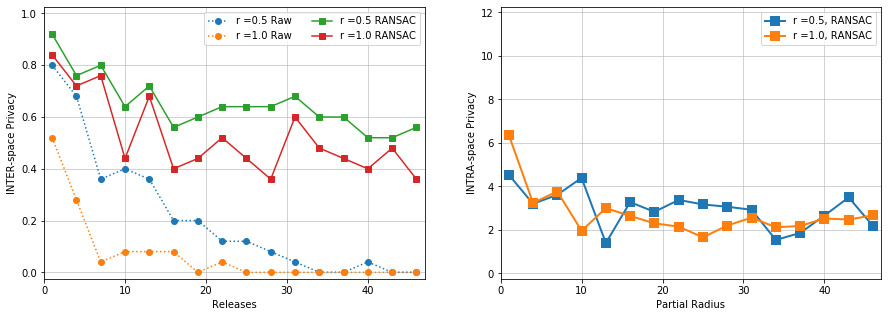

In [18]:
fig=plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,releases-skip)
markersize = 8

ax1.set_ylabel("INTER-space Privacy")
ax1.set_xlabel("Releases")

for radius, RawNN_per_iteration_errors in succ_RawNN_errors:
    print(RawNN_per_iteration_errors.shape)
    ax1.plot(
        np.arange(1,releases-skip,skip),#[:RawNN_per_iteration_errors.shape[1]],
        np.mean(RawNN_per_iteration_errors[:,:,1], axis = 0), 
        ':o',
        label = "r ="+ str(radius) + " Raw"
    )
    
for radius, RansacNN_per_iteration_errors in succ_RansacGeneralizedNN_errors:
    print(RansacNN_per_iteration_errors.shape)
    ax1.plot(
        np.arange(1,releases-skip,skip),
        np.mean(RansacNN_per_iteration_errors[:,:,1], axis = 0),
        '-s',
        label = "r ="+ str(radius) + " RANSAC"
    )

ax1.legend(loc = "best", ncol = 2)

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,12.25)
ax2.set_xlim(0,releases-skip)

ax2.set_ylabel("INTRA-space Privacy")
ax2.set_xlabel("Partial Radius")
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

#plt.minorticks_on()

for radius, errors_per_rel in succ_RansacGeneralizedNN_partial_errors:
    ax2.plot(
        np.arange(1,releases-skip,skip),
        errors_per_rel[:,1], 
        #errors_per_rel[:,2],
        '-s',
        linewidth = 2, #capsize = 4.0, 
        #marker = markers[0],
        #fillstyle = 'none',
        mew = 2, markersize = markersize,
        label = "r ="+ str(radius)+", RANSAC"
    )

ax2.legend(loc = "best")

# Step 3.1 Testing with conservative plane releasing

In [19]:
"""
Parameters:

Also, we use the same successive samples from successive releasing for direct comparability of results.
"""
# We used a radius range of 0.25 to 5.0 in increments of 0.25.
radius_range = radius_range

# For our work, we orignally used 50 samples with further 100 successive releases for our investigation.
# Below are lower parameters, change as desired.
samples = 50
releases = 50

planes = np.arange(1,30,3)

# For demonstration purposes, we skip testing some successive samples but we still accumulate them.
skip = 3

In [ ]:
for radius in radius_range[:2]:
        
    t0 = time.time()
    
    try:
        with open('testing_samples/{}_successive_point_cloud.pickle'.format(radius), 'rb') as f:
            successive_point_collection = pickle.load(f)
    except:
        pass
    
    conservative_scores = []
    conservative_errors = []
    
    for obj_, growing_point_collection in successive_point_collection:
        
        # ROTATION param
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        
        # TRANSLATION param
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        
        per_plane_scores = []
        per_plane_errors = []
        
        latest_plane = 0
        
        for plane_number in planes:
            
            print(radius," {} planes, ({} Done)".format(plane_number,len(per_plane_successive_scores)))
        
            g_iteration_scores = []

            growing_point_cloud = []
            growing_p_point_cloud = []
            growing_p_triangles = []

            release_count = 0
            
            for obj_meta, partial_pointcloud, partial_triangles in growing_point_collection:
                #i_obj, released_growing_point_collection in enumerate(growing_point_collection):

                # ROTATION
                rotated_pointCloud = rotatePointCloud(partial_pointcloud, random_theta, random_axis)

                # TRANSLATION
                t_pointCloud = np.asarray(rotated_pointCloud)
                t_pointCloud[:,random_tx_axis] = t_pointCloud[:,random_tx_axis] + random_translation
                t_triangles = np.asarray(partial_triangles)#-vertices_length

                #RANSAC generalizations
                try:
                    if len(growing_p_point_cloud) == 0:
                        gen_planes = getLOCALIZEDRansacPlanes(
                            pointCloud = t_pointCloud,#np.where(hPointConnectivity < 5)[0],axis = 0),
                            original_vertex = obj_meta[-1],
                            planes_to_find=plane_number
                            #verbose=True
                            #threshold = threshold # the point-plane distance threshold
                        )
                    else:
                        gen_planes = updatePlanesWithSubsumption(
                            new_pointCloud=t_pointCloud,
                            existing_pointCloud=growing_p_point_cloud,
                            planes_to_find = plane_number
                            #verbose=True
                        )
                except:
                    print("Error getting planes",release_count,growing_point_cloud.shape)
                    continue

                if len(gen_planes) == 0:
                    print("No gen planes after release",release_count,growing_point_cloud.shape)
                    continue

                try:
                    updated_point_cloud, updated_triangles = getGeneralizedPointCloud(
                        planes = gen_planes,
                        triangle_area_threshold = 0.2,#2.0*np.amax(getTriangleAreas(partial_pointCloud, partial_triangles))
                        #verbose = True
                    )
                    growing_p_point_cloud = updated_point_cloud
                    growing_p_triangles = updated_triangles

                    #print(" Successful:",release_count,len(growing_p_point_cloud), len(growing_p_triangles),partial_pointCloud.shape)
                except Exception as ex:
                    print("Error getting updated point cloud in release",release_count+1)
                    print(" ",growing_p_point_cloud.shape, growing_p_triangles.shape,partial_pointCloud.shape)
                    #print(ex)
                    continue

                if len(growing_p_point_cloud) == 0:
                    continue

                release_count += 1

                if release_count % skip != 1: # skip 
                    continue

                #RANSAC Processing         
                try:
                    p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                        growing_p_point_cloud,
                        down_resolution = 5,
                        cylindrical_quantization = [4,5]
                    )
                except:
                    p_descriptors = []
                    p_keypoints = []

                    print("Error getting descriptors at release",release_count,"; using next release as this release.")

                    #release_count -= 1

                    continue

                # Resetting the diff_Ratio matrix
                diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
                diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
                diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

                local_keypoint_matches = []

                for i_r, ref_descriptor in enumerate(descriptors):

                    #o_, r_descriptors, r_keypoints, r_d_c
                    r_descriptors = ref_descriptor[1]
                    r_keypoints = ref_descriptor[2]

                    matching_range = np.arange(r_descriptors.shape[1])

                    try:    
                        f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                        diff = diff/np.amax(diff) # max-normalization of differences
                        diff_ratio = diff[:,0]/diff[:,1]
                        diff_ratios[:,i_r] = diff_ratio
                        diff_scores[:,i_r] = diff
                        diff_indexs[:,i_r] = f_nearestneighbor

                        # Taking note of the matched keypoints
                        local_keypoint_matches.append([
                            obj_meta,
                            p_keypoints,
                            r_keypoints[f_nearestneighbor[:,0]]
                        ])

                    except Exception as ex:
                        print(rotation,"Error Matching:",ex)

                # Accumulating the diff_ratio matrix for every partial (rotated) object
                g_iteration_scores.append([
                    obj_meta,
                    diff_ratios,
                    diff_indexs,
                    diff_scores,
                    local_keypoint_matches
                ])

        # --- !
                if release_count % 2 == 0:
                    #print('Test')
                    print("  radius = {} [G]: Done with {} releases ({}) ({} samples). Time to match {:.3f} seconds. ({})".format(
                        radius,
                        len(g_iteration_scores),
                        release_count,
                        len(g_successive_scores),
                        time.time()-t0,
                        growing_p_point_cloud.shape
                    )
                         )
                    t0 = time.time()

                    current_errors = NN_matcher(g_iteration_scores)
                    print("   ({} actual planes) G_Error Rate: {}".format(
                        len(gen_planes),
                        np.sum(current_errors[:,1]/len(g_iteration_scores))
                    ))

                g_iteration_errors = NN_matcher(g_iteration_scores)
            try:
                print(radius,plane_number,len(g_successive_scores),"G_Error Rate:",np.sum(g_iteration_errors[:,1]/len(g_iteration_scores)))
            except:
                pass

            per_plane_scores.append([
                plane_number,
                g_iteration_scores
            ])

            per_plane_errors.append([
                plane_number,
                g_iteration_errors
            ])

        conservative_scores.append([
            obj_,
            per_plane_scores
        ])

        conservative_errors.append([
            obj_,
            per_plane_errors
        ])
        
        if len(successive_scores) % 5 == (samples-1)%5 :
            try:
                print("Radius = {}, {} objects done".format(radius,len(g_successive_scores)))
            except:
                pass
            
        with open('testing_results/conservative/radius_{}_RANSAC_conservative_scores.pickle'.format(radius), 'wb') as f:
            pickle.dump(conservative_scores,f)

        with open('testing_results/conservative/radius_{}_RANSAC_conservative_errors.pickle'.format(radius), 'wb') as f:
            pickle.dump(conservative_errors,f)
                

0.5  1 planes, (0 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (0 samples). Time to match 2.761 seconds. ((405, 6))
   (1 actual planes) G_Error Rate: 0.5
  radius = 0.5 [G]: Done with 4 releases (10) (0 samples). Time to match 7.832 seconds. ((700, 6))
   (1 actual planes) G_Error Rate: 0.75
  radius = 0.5 [G]: Done with 6 releases (16) (0 samples). Time to match 11.805 seconds. ((2685, 6))
   (1 actual planes) G_Error Rate: 0.8333333333333333
  radius = 0.5 [G]: Done with 8 releases (22) (0 samples). Time to match 13.773 seconds. ((2685, 6))
   (1 actual planes) G_Error Rate: 0.875
  radius = 0.5 [G]: Done with 10 releases (28) (0 samples). Time to match 13.880 seconds. ((2685, 6))
   (1 actual planes) G_Error Rate: 0.9
  radius = 0.5 [G]: Done with 12 releases (34) (0 samples). Time to match 12.884 seconds. ((2685, 6))
   (1 actual planes) G_Error Rate: 0.9166666666666667
  radius = 0.5 [G]: Done with 14 releases (40) (0 samples). Time to match 13.789 seconds. ((2685, 6))
   (

  radius = 0.5 [G]: Done with 14 releases (40) (0 samples). Time to match 74.034 seconds. ((11813, 6))
   (11 actual planes) G_Error Rate: 0.857142857142857
  radius = 0.5 [G]: Done with 16 releases (46) (0 samples). Time to match 75.909 seconds. ((11651, 6))
   (11 actual planes) G_Error Rate: 0.875
0.5 19 0 G_Error Rate: 0.8823529411764706
0.5  22 planes, (7 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (0 samples). Time to match 44.648 seconds. ((1475, 6))
   (2 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (0 samples). Time to match 16.488 seconds. ((1802, 6))
   (4 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 6 releases (16) (0 samples). Time to match 24.602 seconds. ((4777, 6))
   (4 actual planes) G_Error Rate: 0.9999999999999999
  radius = 0.5 [G]: Done with 8 releases (22) (0 samples). Time to match 29.081 seconds. ((3898, 6))
   (5 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 10 releases (28) (0 samples

  radius = 0.5 [G]: Done with 16 releases (46) (1 samples). Time to match 52.889 seconds. ((5937, 6))
   (10 actual planes) G_Error Rate: 0.5625
0.5 10 1 G_Error Rate: 0.5294117647058822
0.5  13 planes, (4 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (1 samples). Time to match 37.980 seconds. ((1916, 6))
   (9 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (1 samples). Time to match 21.321 seconds. ((2845, 6))
   (11 actual planes) G_Error Rate: 0.75
  radius = 0.5 [G]: Done with 6 releases (16) (1 samples). Time to match 25.834 seconds. ((3429, 6))
   (12 actual planes) G_Error Rate: 0.8333333333333333
  radius = 0.5 [G]: Done with 8 releases (22) (1 samples). Time to match 32.162 seconds. ((3946, 6))
   (12 actual planes) G_Error Rate: 0.875
  radius = 0.5 [G]: Done with 10 releases (28) (1 samples). Time to match 45.063 seconds. ((5963, 6))
   (12 actual planes) G_Error Rate: 0.9
  radius = 0.5 [G]: Done with 12 releases (34) (1 samples). Time t

  radius = 0.5 [G]: Done with 10 releases (28) (2 samples). Time to match 3.620 seconds. ((978, 6))
   (1 actual planes) G_Error Rate: 0.8
0.5 1 2 G_Error Rate: 0.8
0.5  4 planes, (1 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (2 samples). Time to match 7.412 seconds. ((764, 6))
   (4 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (2 samples). Time to match 17.254 seconds. ((2366, 6))
   (4 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 6 releases (16) (2 samples). Time to match 22.507 seconds. ((2895, 6))
   (4 actual planes) G_Error Rate: 0.9999999999999999
  radius = 0.5 [G]: Done with 8 releases (22) (2 samples). Time to match 26.461 seconds. ((3219, 6))
   (4 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 10 releases (28) (2 samples). Time to match 29.157 seconds. ((3730, 6))
   (4 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 12 releases (34) (2 samples). Time to match 27.660 seconds. ((2806, 

  radius = 0.5 [G]: Done with 12 releases (34) (2 samples). Time to match 48.951 seconds. ((5260, 6))
   (20 actual planes) G_Error Rate: 0.9166666666666667
  radius = 0.5 [G]: Done with 14 releases (40) (2 samples). Time to match 51.361 seconds. ((5993, 6))
   (20 actual planes) G_Error Rate: 0.857142857142857
  radius = 0.5 [G]: Done with 16 releases (46) (2 samples). Time to match 54.206 seconds. ((6151, 6))
   (21 actual planes) G_Error Rate: 0.875
0.5 22 2 G_Error Rate: 0.8823529411764706
0.5  25 planes, (8 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (2 samples). Time to match 41.199 seconds. ((1071, 6))
   (7 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (2 samples). Time to match 34.836 seconds. ((3034, 6))
   (14 actual planes) G_Error Rate: 0.75
  radius = 0.5 [G]: Done with 6 releases (16) (2 samples). Time to match 45.751 seconds. ((4840, 6))
   (17 actual planes) G_Error Rate: 0.8333333333333333
  radius = 0.5 [G]: Done with 8 release

  radius = 0.5 [G]: Done with 8 releases (22) (3 samples). Time to match 29.451 seconds. ((3528, 6))
   (9 actual planes) G_Error Rate: 0.5
  radius = 0.5 [G]: Done with 10 releases (28) (3 samples). Time to match 58.886 seconds. ((7937, 6))
   (13 actual planes) G_Error Rate: 0.4
  radius = 0.5 [G]: Done with 12 releases (34) (3 samples). Time to match 56.931 seconds. ((6647, 6))
   (13 actual planes) G_Error Rate: 0.3333333333333333
  radius = 0.5 [G]: Done with 14 releases (40) (3 samples). Time to match 57.166 seconds. ((6835, 6))
   (13 actual planes) G_Error Rate: 0.2857142857142857
  radius = 0.5 [G]: Done with 16 releases (46) (3 samples). Time to match 59.302 seconds. ((7894, 6))
   (13 actual planes) G_Error Rate: 0.25
0.5 13 3 G_Error Rate: 0.23529411764705882
0.5  16 planes, (5 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (3 samples). Time to match 36.950 seconds. ((265, 6))
   (2 actual planes) G_Error Rate: 0.5
  radius = 0.5 [G]: Done with 4 releases (10) (3 sample

# 3.2 Results with conservative plane releasing

In [ ]:
conservative_RANSAC_error_results = []

t0 = time.time()

for radius in radius_range[:2]:
    
    succ_RansacGeneralizedNN_per_iteration_errors = []
    
    try:
                
        with open('testing_results/conservative/radius_{}_RANSAC_conservative_scores.pickle'.format(radius), 'rb') as f:
            conservative_scores = pickle.load(f)

        with open('testing_results/conservative/radius_{}_RANSAC_conservative_errors.pickle'.format(radius), 'rb') as f:
            conservative_errors = pickle.load(f)
        
        for obj_, per_plane_scores in successive_scores:#[:-1]:  
            
            per_plane_errors = []
            
            skip = False
            
            for planes, iteration_scores in per_plane_scores:
                #print(iteration_errors.shape)
                
                iteration_errors = NN_matcher(iteration_scores)
                
                #print(planes,iteration_errors.shape)

                if iteration_errors.shape[0] >=18:
                    per_plane_errors.append(iteration_errors[:18])
                else:
                    skip = True
                    #print("RANSAC: skipped",iteration_errors.shape)
                    
            if not skip:
                succ_RansacGeneralizedNN_per_iteration_errors.append(per_plane_errors)
       
        conservative_RANSAC_error_results.append([
            radius,
            succ_RansacGeneralizedNN_per_iteration_errors
        ])
              
    except Exception as ex:
        print(radius,": successive RansacNN\n  ", ex)
        pass
    
    
    print("Done with radius = {:.2f} in {:.3f} seconds".format(radius,time.time() - t0))
    t0 = time.time()
    
"""
# Uncomment below if you want to overwrite the existing results.
"""
with open('testing_results/conservative/conservative_RANSAC_error_results.pickle', 'wb') as f:
    pickle.dump(conservative_RANSAC_error_results,f)

In [ ]:
"""

Preparing the results of the case with *Conservative Releasing*.

"""

releases_range = np.arange(1,releases-skip,skip)

X, Y = np.meshgrid(releases_range, planes)

test_vp_cn_05 = np.asarray(conservative_RANSAC_error_results[0][1])
mean_vp_cn_05 = np.mean(test_vp_cn_05[:,:,:,1],axis = 0)

test_vp_cn_10 = np.asarray(conservative_RANSAC_error_results[1][1])
mean_vp_cn_05 = np.mean(test_vp_cn_05[:,:,:,1],axis = 0)

intra_vp_cn_10 = np.zeros(test_vp_cn_10.shape[1:])
intra_vp_cn_05 = np.zeros(test_vp_cn_05.shape[1:])

for plane_i, plane in enumerate(planes):
        
    for rel_i, rel in enumerate(releases_range):
    
        correct_interspace_labels_idxs_05 = np.where(test_vp_cn_05[:,plane_i,rel_i,1]==0)[0]
        correct_interspace_labels_idxs_10 = np.where(test_vp_cn_10[:,plane_i,rel_i,1]==0)[0]

        intraspace_errors_05  = test_vp_cn_05[correct_interspace_labels_idxs_05,plane_i,rel_i,2]
        intraspace_errors_10  = test_vp_cn_10[correct_interspace_labels_idxs_10,plane_i,rel_i,2]
        
        intra_vp_cn_05[plane_i,rel_i] = np.asarray([
            np.mean(intraspace_errors_05),
            np.std(intraspace_errors_05),
            0,
            np.nan
        ])
        
        intra_vp_cn_10[plane_i,rel_i] = np.asarray([
            np.mean(intraspace_errors_10),
            np.std(intraspace_errors_10),
            0,
            np.nan
        ])

In [ ]:
fig = plt.figure(figsize=(11,8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(
    X, Y, 
    mean_vp_cn_05, 
    cmap=plt.cm.plasma,
)
surf.set_clim(0.0,1.0)

ax.set_title("r = 0.5", fontsize = 24)
ax.set_xlabel("Releases", labelpad=10, fontsize = 24)
ax.set_xlim(0,100)
ax.set_xticklabels(np.arange(0,101,20),fontsize = 16)
ax.set_zlabel("INTER-space Privacy", labelpad=10, fontsize = 24)
ax.set_zlim(0,1)
ax.set_zticklabels([0,0.2,0.4,0.6,0.8,1.0],fontsize = 16)
ax.set_ylabel("Max number of planes", labelpad=10, fontsize = 22)#, offset = 1)
ax.set_ylim(0,30)
ax.set_yticklabels(np.arange(0,35,5),fontsize = 16)

cbar = fig.colorbar(surf, aspect=30, ticks = np.arange(0.0,1.1,0.25))
cbar.ax.set_yticklabels(np.arange(0.0,1.1,0.25),fontsize = 16)

ax.view_init(25,135);